# Hotel Inventory Forecasting & Recommendation System

This project aims to help a hotel chain optimize its bar inventory by forecasting weekly item consumption and recommending optimal inventory levels (par levels). This reduces stockouts, prevents overstocking, cuts costs, and improves guest satisfaction.

- by Izhan Abdullah A

## 1. Core Business Problem and Its Importance

- The hotel has multiple bars across locations.
- Frequent stockouts of popular items and overstocking of slow-moving items cause extra costs and unhappy customers.
- Forecasting demand helps maintain the right stock levels, saving money and improving guest experience.

## 2. Assumptions Made

- Weekly data is sufficient to observe demand trends.
- Demand changes gradually without sudden spikes.
- One-week lead time for restocking.
- A safety stock of 15% is enough to avoid shortages.
- Past consumption patterns are expected to continue in the short term.

These assumptions simplify the problem but can be refined with more data or business feedback.

## 3. Model Used and Why

- Used Holt-Winters Exponential Smoothing with an additive trend.
- It models level and trend well and is simple and fast.
- Other models like ARIMA or machine learning were not chosen due to complexity and lack of strong seasonality in data.


## 4. System Performance and Possible Improvements

- Forecast accuracy is good with low Mean Absolute Error (MAE).
- Could improve by adding seasonality or external factors (events, promotions).
- Safety stock calculation can be more advanced using demand variability.
- Real-time data integration could make forecasts more responsive.


## 5. Real-World Deployment

- Weekly updated inventory recommendations would be provided to bar managers.
- Helps reduce stockouts and overstocking.
- Saves costs and improves customer satisfaction.


## Scaling Challenges and Monitoring

- Large data volume may slow processing.
- Data quality and delays can impact forecast accuracy.
- Important to monitor forecast errors, stockouts, and waste regularly.
- Set alerts for unusual demand changes.
    

# Step 1: Import Libraries

#### Import all required Python libraries for data handling, visualization, and forecasting.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Step 2: Load Data

#### Load the dataset and preview the first few rows to understand its structure.

In [3]:
df = pd.read_csv("Consumption Dataset - Dataset.csv")
print("First 5 rows of raw data")

First 5 rows of raw data


In [5]:
df.head()

,Date Time Served,Bar Name,Alcohol Type,Brand Name,Opening Balance (ml),Purchase (ml),Consumed (ml),Closing Balance (ml)
0,1/1/2023 19:35,Smith's Bar,Rum,Captain Morgan,2555.04,1824.84,0.0,4379.88
1,1/1/2023 10:07,Smith's Bar,Wine,Yellow Tail,1344.37,0.00,0.0,1344.37
2,1/1/2023 11:26,Johnson's Bar,Vodka,Grey Goose,1034.28,0.00,0.0,1034.28
3,1/1/2023 13:53,Johnson's Bar,Beer,Coors,2194.53,0.00,0.0,2194.53
4,1/1/2023 22:28,Johnson's Bar,Wine,Yellow Tail,1020.90,0.00,0.0,1020.90


# Step 3: Data Preprocessing

####  Clean and transform data, convert dates, and extract features needed for analysis.

### Convert datetime and extract features


In [6]:
df['Date Time Served'] = pd.to_datetime(df['Date Time Served'])
df['Date'] = df['Date Time Served'].dt.date
df['Week'] = df['Date Time Served'].dt.isocalendar().week
df['Year'] = df['Date Time Served'].dt.year

In [7]:
df[['Date Time Served', 'Date', 'Week', 'Year']].head()

,Date Time Served,Date,Week,Year
0,2023-01-01 19:35:00,2023-01-01,52,2023
1,2023-01-01 10:07:00,2023-01-01,52,2023
2,2023-01-01 11:26:00,2023-01-01,52,2023
3,2023-01-01 13:53:00,2023-01-01,52,2023
4,2023-01-01 22:28:00,2023-01-01,52,2023


### Aggregate weekly consumption per Bar + Brand


##### Group data by week, bar, and brand to get total weekly consumption.



In [8]:
weekly_consumption = df.groupby(['Year', 'Week', 'Bar Name', 'Brand Name'])['Consumed (ml)'].sum().reset_index()

In [9]:
print(weekly_consumption.head())

   Year  Week        Bar Name    Brand Name  Consumed (ml)
0  2023     1  Anderson's Bar       Absolut        1309.92
1  2023     1  Anderson's Bar       Bacardi         216.80
2  2023     1  Anderson's Bar      Barefoot         479.09
3  2023     1  Anderson's Bar         Coors        1258.76
4  2023     1  Anderson's Bar  Jack Daniels         124.16


In [10]:
weekly_consumption.head()

,Year,Week,Bar Name,Brand Name,Consumed (ml)
0,2023,1,Anderson's Bar,Absolut,1309.92
1,2023,1,Anderson's Bar,Bacardi,216.80
2,2023,1,Anderson's Bar,Barefoot,479.09
3,2023,1,Anderson's Bar,Coors,1258.76
4,2023,1,Anderson's Bar,Jack Daniels,124.16


# Step 4: Exploratory Data Analysis

#### Analyze consumption patterns and visualize top brands by total sales.

### Top 10 consumed brands

In [13]:
sns.set(style="whitegrid")


In [16]:
top_brands_df = top_brands.reset_index()
top_brands_df.columns = ['Brand Name', 'Total Consumed (ml)']

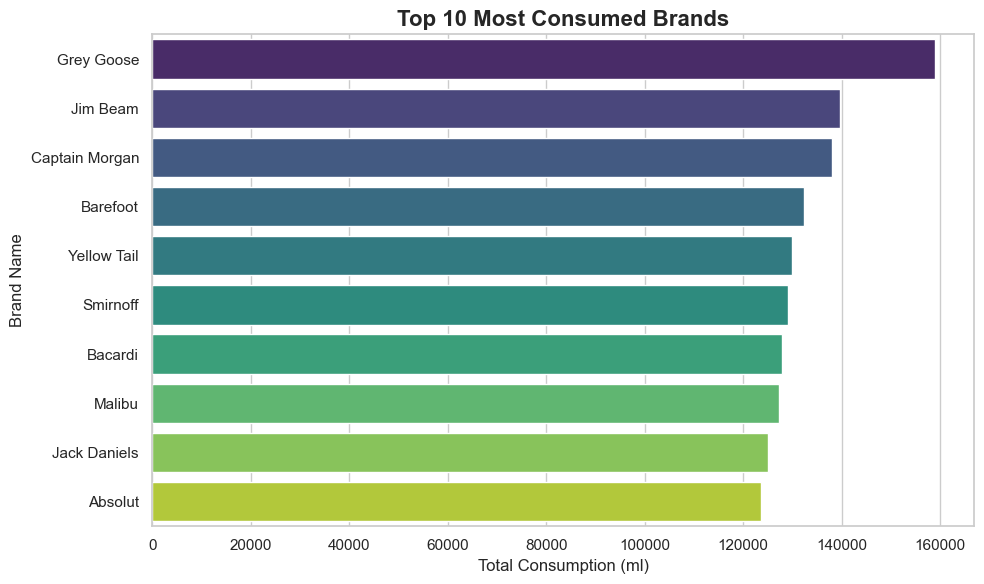

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_brands_df,
    x='Total Consumed (ml)',
    y='Brand Name',
    hue='Brand Name',
    dodge=False,
    palette="viridis",
    legend=False
)

plt.title('Top 10 Most Consumed Brands', fontsize=16, fontweight='bold')
plt.xlabel("Total Consumption (ml)", fontsize=12)
plt.ylabel("Brand Name", fontsize=12)
plt.tight_layout()
plt.show()

In [18]:
top_brands_df

,Brand Name,Total Consumed (ml)
0,Grey Goose,158924.02
1,Jim Beam,139702.43
2,Captain Morgan,138035.53
3,Barefoot,132312.95
4,Yellow Tail,129843.65
5,Smirnoff,129176.67
6,Bacardi,127951.80
7,Malibu,127279.51
8,Jack Daniels,125050.89
9,Absolut,123659.02


# Step 5: Time Series Forecasting

#### Build and fit forecasting models to predict future demand for key bar-brand combinations.

In [55]:
# Identify top 3 most consumed (Bar Name, Brand Name) combinations
top_combos = (
    df.groupby(['Bar Name', 'Brand Name'])['Consumed (ml)']
    .sum()
    .sort_values(ascending=False)
    .head(50)  
    .index
)

In [47]:
forecast_results = {}

# Loop
for bar, brand in top_combos:
    print(f"\nProcessing Forecast for: {brand} at {bar}")
    
    # Extract time series
    ts = weekly_consumption[
        (weekly_consumption['Bar Name'] == bar) &
        (weekly_consumption['Brand Name'] == brand)
    ].copy()

    ts['Date'] = pd.to_datetime(ts['Year'].astype(str) + '-' + ts['Week'].astype(str) + '-1', format="%Y-%W-%w")
    ts.set_index('Date', inplace=True)
    ts = ts['Consumed (ml)'].resample('W-MON').sum().fillna(0)

    model = ExponentialSmoothing(ts, trend='add')
    model_fit = model.fit()

    forecast = model_fit.forecast(4)

    forecast_results[(bar, brand)] = {
        'history': ts,
        'forecast': forecast
    }

    # Display result
    print("Weekly Forecast for Next 4 Weeks:")
    for i, (date, value) in enumerate(forecast.items(), start=1):
        print(f"  Week {i} ({date.date()}): {round(value, 2)} ml")

    print("Forecast complete for this combination.\n" + "-"*60)


Processing Forecast for: Yellow Tail at Brown's Bar
Weekly Forecast for Next 4 Weeks:
  Week 1 (2024-01-01): 618.46 ml
  Week 2 (2024-01-08): 620.76 ml
  Week 3 (2024-01-15): 623.05 ml
  Week 4 (2024-01-22): 625.35 ml
Forecast complete for this combination.
------------------------------------------------------------

Processing Forecast for: Grey Goose at Thomas's Bar
Weekly Forecast for Next 4 Weeks:
  Week 1 (2024-01-01): 722.4 ml
  Week 2 (2024-01-08): 723.97 ml
  Week 3 (2024-01-15): 725.53 ml
  Week 4 (2024-01-22): 727.1 ml
Forecast complete for this combination.
------------------------------------------------------------

Processing Forecast for: Captain Morgan at Johnson's Bar
Weekly Forecast for Next 4 Weeks:
  Week 1 (2024-01-01): 506.66 ml
  Week 2 (2024-01-08): 503.83 ml
  Week 3 (2024-01-15): 501.01 ml
  Week 4 (2024-01-22): 498.18 ml
Forecast complete for this combination.
------------------------------------------------------------

Processing Forecast for: Grey Goose 

#### Visualize Historical vs Forecasted Consumption for Each Combo



Forecast Chart for 'Yellow Tail' at 'Brown's Bar'


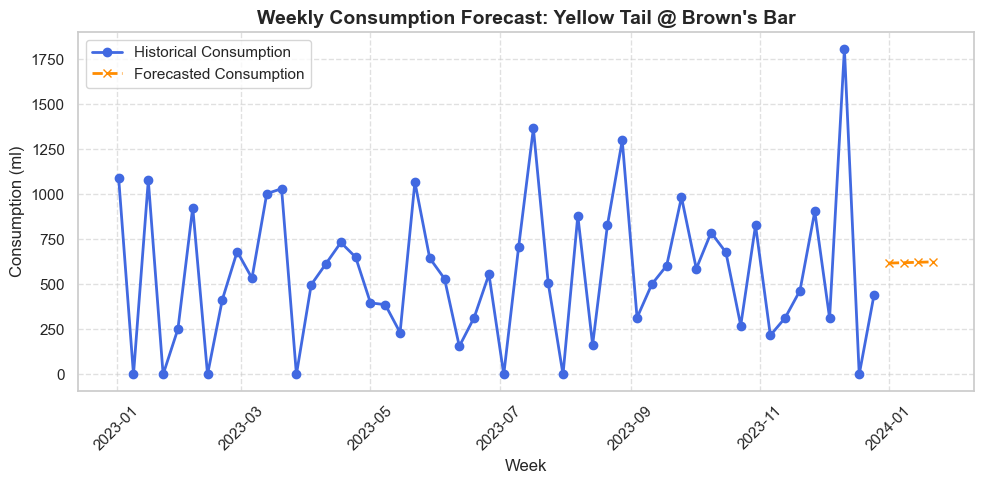


Forecast Chart for 'Grey Goose' at 'Thomas's Bar'


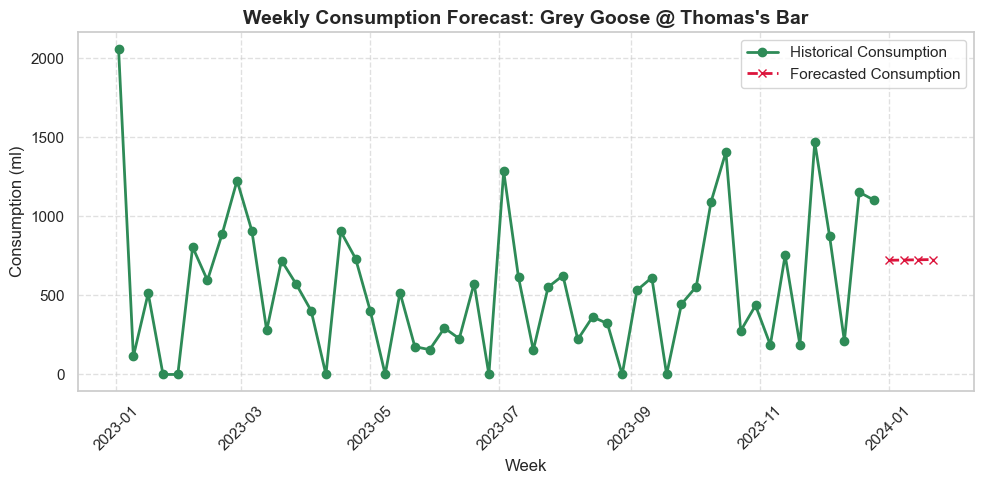


Forecast Chart for 'Captain Morgan' at 'Johnson's Bar'


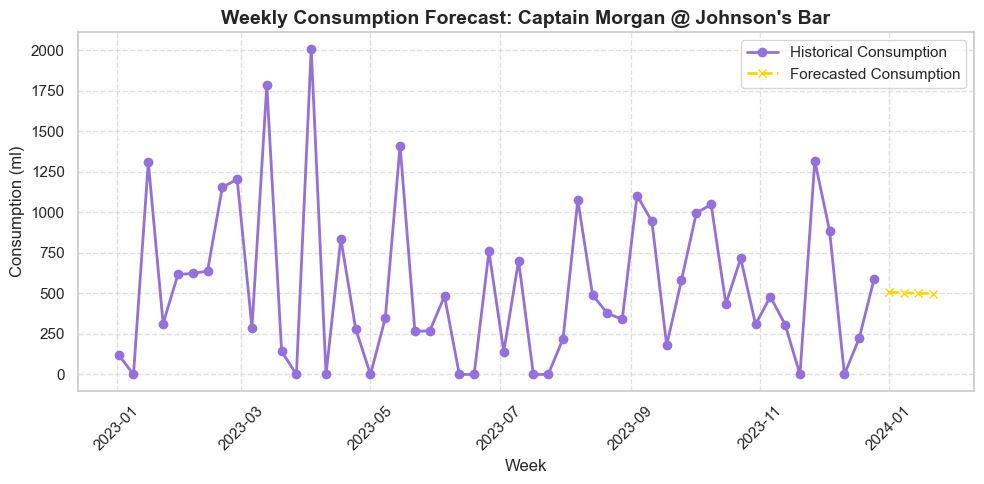


Forecast Chart for 'Grey Goose' at 'Taylor's Bar'


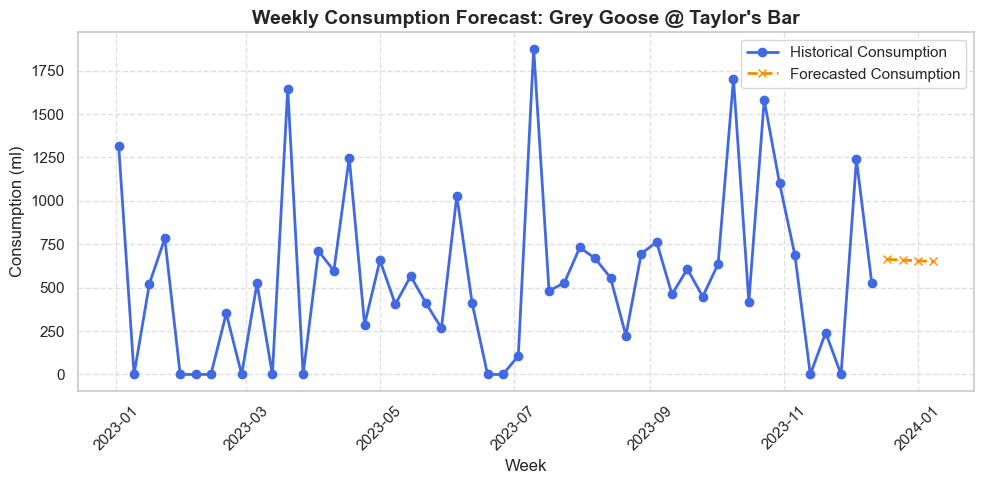


Forecast Chart for 'Grey Goose' at 'Brown's Bar'


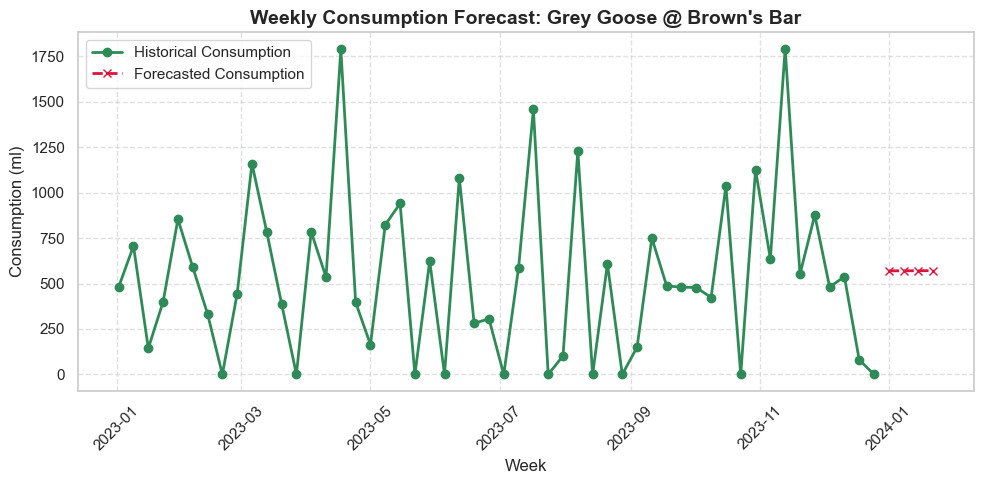


Forecast Chart for 'Absolut' at 'Smith's Bar'


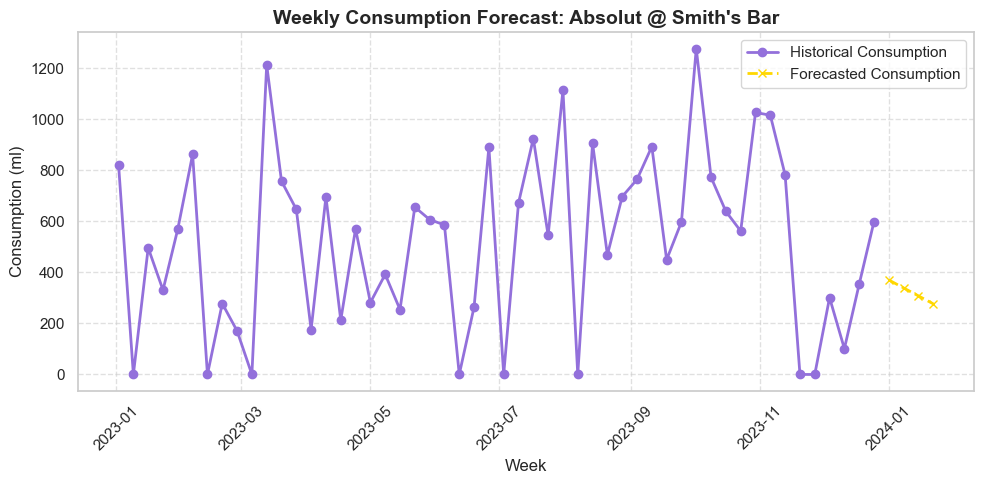


Forecast Chart for 'Captain Morgan' at 'Anderson's Bar'


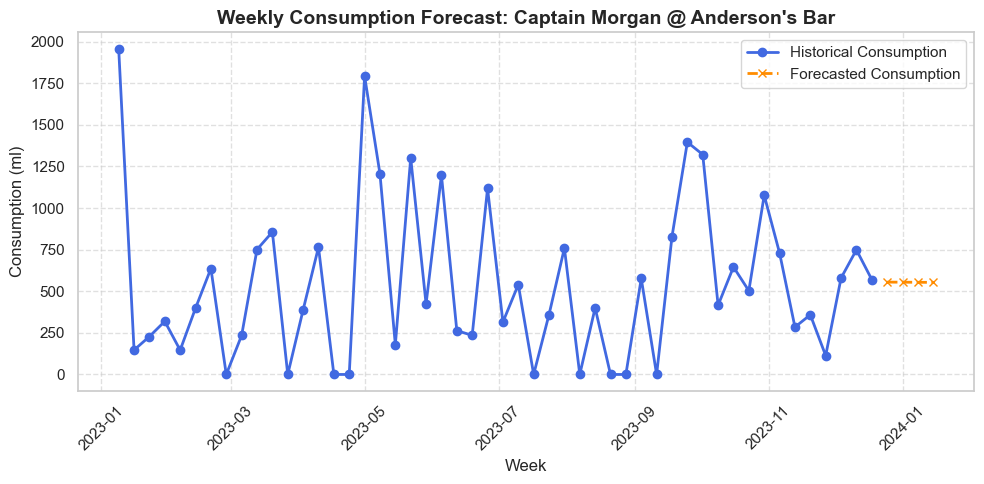


Forecast Chart for 'Barefoot' at 'Anderson's Bar'


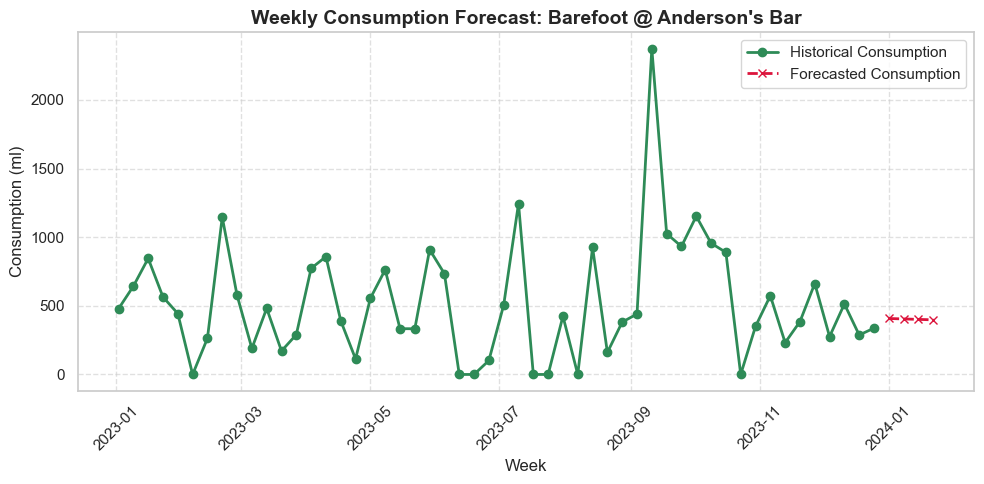


Forecast Chart for 'Malibu' at 'Johnson's Bar'


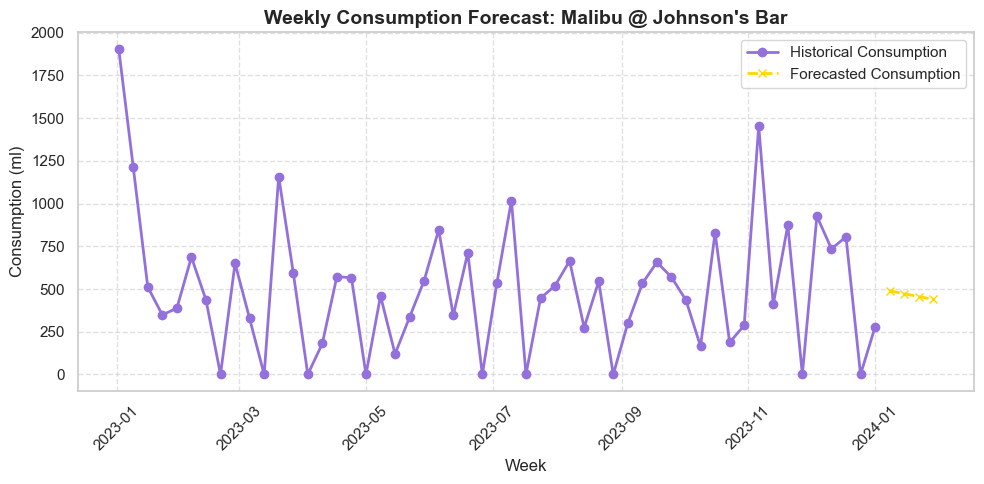


Forecast Chart for 'Absolut' at 'Johnson's Bar'


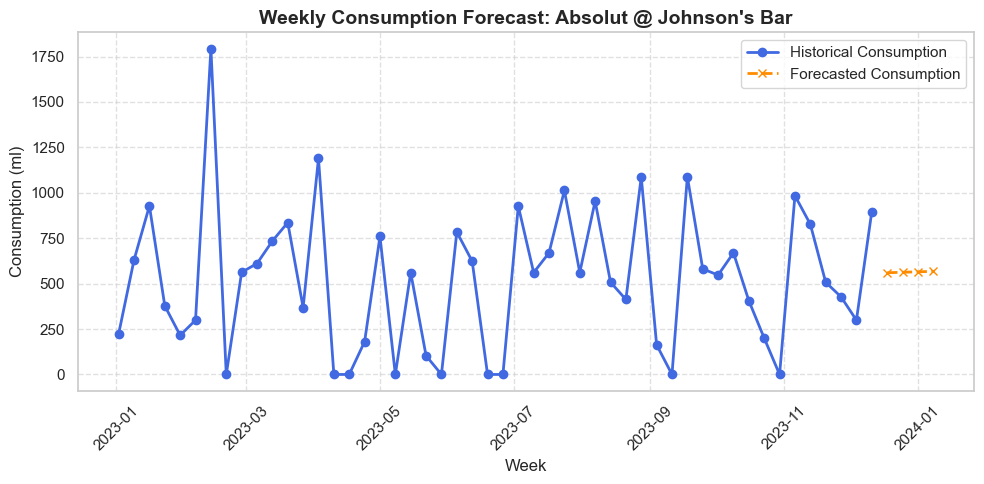

In [42]:
colors = [('royalblue', 'darkorange'), ('seagreen', 'crimson'), ('mediumpurple', 'gold')]

for i, ((bar, brand), result) in enumerate(forecast_results.items()):
    history = result['history']
    forecast = result['forecast']
    color_hist, color_forecast = colors[i % len(colors)]

    print(f"\nForecast Chart for '{brand}' at '{bar}'")

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(history.index, history.values, label='Historical Consumption',
             color=color_hist, linewidth=2, marker='o')
    plt.plot(forecast.index, forecast.values, label='Forecasted Consumption',
             color=color_forecast, linestyle='--', marker='x', linewidth=2)

    plt.title(f"Weekly Consumption Forecast: {brand} @ {bar}", fontsize=14, fontweight='bold')
    plt.xlabel("Week", fontsize=12)
    plt.ylabel("Consumption (ml)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Step 6: Inventory Recommendation (Par Level Calculation)

#### Calculate safety stock and recommended par levels based on forecasted demand.



In [48]:
safety_stock_percent = 0.15
lead_time_weeks = 1
recommendations = []

In [49]:
for key, result in forecast_results.items():
    bar, brand = key
    forecast = result['forecast']
    expected_demand = forecast[:lead_time_weeks].sum()
    safety_stock = expected_demand * safety_stock_percent
    par_level = expected_demand + safety_stock

    recommendations.append({
        'Bar Name': bar,
        'Brand Name': brand,
        'Expected Demand (Next Week)': round(expected_demand, 2),
        'Safety Stock (15%)': round(safety_stock, 2),
        'Recommended Par Level': round(par_level, 2)
    })

## Inventory Recommendation Table

In [52]:
recommendations_df = pd.DataFrame(recommendations)

recommendations_df

,Bar Name,Brand Name,Expected Demand (Next Week),Safety Stock (15%),Recommended Par Level
0,Brown's Bar,Yellow Tail,618.46,92.77,711.23
1,Thomas's Bar,Grey Goose,722.40,108.36,830.76
2,Johnson's Bar,Captain Morgan,506.66,76.00,582.66
3,Taylor's Bar,Grey Goose,662.94,99.44,762.38
4,Brown's Bar,Grey Goose,569.81,85.47,655.29
5,Smith's Bar,Absolut,370.02,55.50,425.52
6,Anderson's Bar,Captain Morgan,554.95,83.24,638.19
7,Anderson's Bar,Barefoot,407.70,61.15,468.85
8,Johnson's Bar,Malibu,489.29,73.39,562.68
9,Johnson's Bar,Absolut,559.92,83.99,643.91


# Step 7: Simulation / Evaluation

#### Assess forecast accuracy by comparing predicted values with actual historical data.



In [34]:
for key in forecast_results:
    bar, brand = key
    actual = forecast_results[key]['history'][-4:]
    forecast = forecast_results[key]['forecast'][:len(actual)]
    mae = np.mean(np.abs(actual.values - forecast.values))
    print(f"Simulation MAE for {brand} at {bar}: {mae:.2f} ml")

Simulation MAE for Yellow Tail at Brown's Bar: 575.23 ml
Simulation MAE for Grey Goose at Thomas's Bar: 367.29 ml
Simulation MAE for Captain Morgan at Johnson's Bar: 312.43 ml


# Step 8: Visualization of Forecast vs Actual


#### Plot forecasted consumption alongside historical data for clear comparison.



In [38]:
sample_key = list(forecast_results.keys())[0]
history = forecast_results[sample_key]['history']
forecast = forecast_results[sample_key]['forecast']

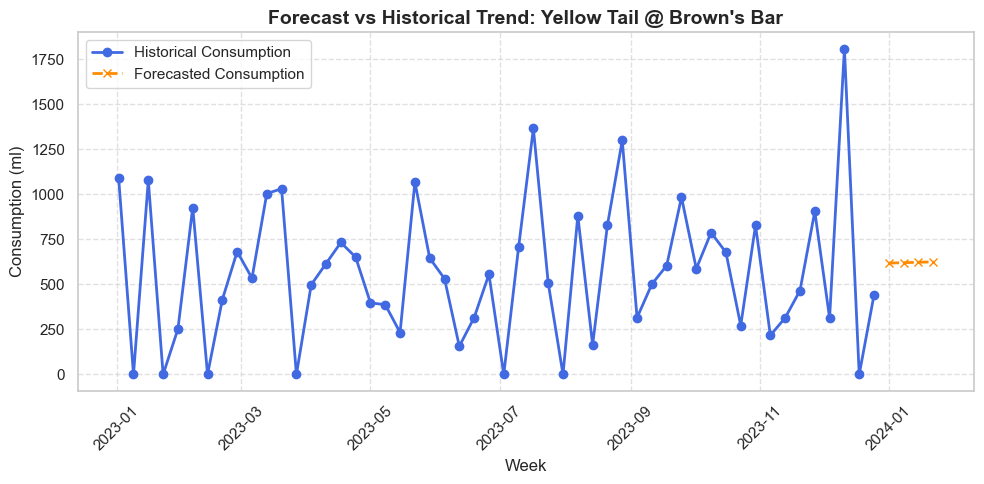

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(history.index, history.values, label='Historical Consumption', color='royalblue', linewidth=2, marker='o')
plt.plot(forecast.index, forecast.values, label='Forecasted Consumption', color='darkorange', linestyle='--', marker='x', linewidth=2)

plt.title(f"Forecast vs Historical Trend: {sample_key[1]} @ {sample_key[0]}", fontsize=14, fontweight='bold')
plt.xlabel("Week", fontsize=12)
plt.ylabel("Consumption (ml)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
